In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd drive/MyDrive

/content/drive/MyDrive


In [ ]:
%cd Image Denoising

/content/drive/MyDrive/Image Denoising


In [ ]:
%cd DnCNN

/content/drive/MyDrive/Image Denoising/DnCNN


In [ ]:
%cd src

/content/drive/MyDrive/Image Denoising/DnCNN/src


In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as td
import torchvision as tv
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import nntools as nt
import time
import random

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [ ]:
def myimshow(image, ax=plt):
    image = image.to('cpu').numpy()
    image = np.moveaxis(image, [0, 1, 2], [2, 0, 1])
    image = (image + 1) / 2
    image[image < 0] = 0
    image[image > 1] = 1
    image = image.squeeze()
    h = ax.imshow(image, cmap = 'gray')
    ax.axis('off')
    return h

In [ ]:
class NoisyBSDSDataset2(td.Dataset):

    def __init__(self, root_dir, mode='train', image_size=(180, 180), sigma=30):
        super(NoisyBSDSDataset2, self).__init__()
        self.mode = mode
        self.image_size = image_size
        self.sigma = sigma
        self.images_dir = os.path.join(root_dir, mode)
        self.files = os.listdir(self.images_dir)

    def __len__(self):
        return len(self.files)

    def __repr__(self):
        return "NoisyBSDSDataset2(mode={}, image_size={}, sigma={})"
        format(self.mode, self.image_size, self.sigma)

    def __getitem__(self, idx):
        img_path = os.path.join(self.images_dir, self.files[0])
        clean = Image.open(img_path).convert('RGB')
        clean = ImageOps.grayscale(clean);
        '''# random crop
        i = np.random.randint(clean.size[0] - self.image_size[0])
        j = np.random.randint(clean.size[1] - self.image_size[1])

        clean = clean.crop([i, j, i+self.image_size[0], j+self.image_size[1]])'''
        transform = tv.transforms.Compose([
            # convert it to a tensor
            tv.transforms.ToTensor(),
            # normalize it to the range [−1, 1]
            tv.transforms.Normalize((.5), (.5))
            ])
        clean = transform(clean)
        img_path = os.path.join(self.images_dir, self.files[idx])
        #print(idx,self.files[idx])
        noisy = Image.open(img_path).convert('RGB')
        noisy = ImageOps.grayscale(noisy);
        noisy = transform(noisy)
        return noisy, clean

In [ ]:
class NoisyBSDSDataset3(td.Dataset):

    def __init__(self, root_dir, mode='train', image_size=(180, 180), sigma=30):
        super(NoisyBSDSDataset3, self).__init__()
        self.mode = mode
        self.image_size = image_size
        self.sigma = sigma
        self.images_dir = os.path.join(root_dir, mode)
        self.files = os.listdir(self.images_dir)

    def __len__(self):
        return len(self.files)

    def __repr__(self):
        return "NoisyBSDSDataset2(mode={}, image_size={}, sigma={})"
        format(self.mode, self.image_size, self.sigma)

    def __getitem__(self, idx):
        img_path = os.path.join(self.images_dir, self.files[0])
        clean = Image.open(img_path).convert('RGB')
        clean = ImageOps.grayscale(clean);
        '''# random crop
        i = np.random.randint(clean.size[0] - self.image_size[0])
        j = np.random.randint(clean.size[1] - self.image_size[1])

        clean = clean.crop([i, j, i+self.image_size[0], j+self.image_size[1]])'''
        transform = tv.transforms.Compose([
            # convert it to a tensor
            tv.transforms.ToTensor(),
            # normalize it to the range [−1, 1]
            tv.transforms.Normalize((.5), (.5))
            ])
        clean = transform(clean)
        img_path = os.path.join(self.images_dir, self.files[idx])
        print(idx,self.files[idx])
        noisy = Image.open(img_path).convert('RGB')
        noisy = ImageOps.grayscale(noisy);
        noisy = transform(noisy)
        return noisy, clean

In [ ]:
dataset_root_dir2 = '../exp1/images'
dataset_root_dir3 = '../exp1/images'


In [ ]:
train_set = NoisyBSDSDataset2(dataset_root_dir2)
test_set = NoisyBSDSDataset3(dataset_root_dir2, mode='test')

In [ ]:
for i in range(25):
    test_set[i]

0 199.png
1 g10_9.png
2 g20_9.png
3 g30_9.png
4 g40_9.png
5 g50_9.png
6 g60_9.png
7 g70_9.png
8 g80_9.png
9 p10_9.png
10 p20_9.png
11 p30_9.png
12 p40_9.png
13 p50_9.png
14 p60_9.png
15 p70_9.png
16 p80_9.png
17 s10_9.png
18 s20_9.png
19 s30_9.png
20 s40_9.png
21 s50_9.png
22 s60_9.png
23 s70_9.png
24 s80_9.png


image size is torch.Size([1, 128, 128]).


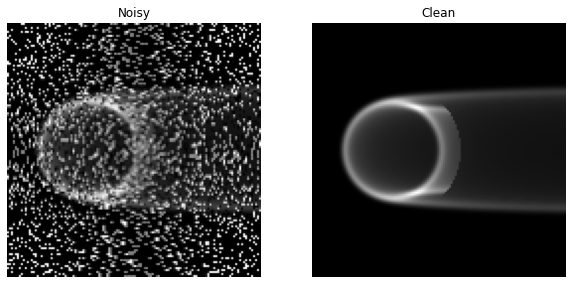

In [ ]:
x = train_set[39]
fig, axes = plt.subplots(ncols=2, figsize = (10,6))
myimshow(x[0], ax=axes[0])
axes[0].set_title('Noisy')
myimshow(x[1], ax=axes[1])
axes[1].set_title('Clean')
print(f'image size is {x[0].shape}.')

In [ ]:
class NNRegressor(nt.NeuralNetwork):

    def __init__(self):
        super(NNRegressor, self).__init__()
        self.mse = nn.MSELoss()

    def criterion(self, y, d):
        return self.mse(y, d)

In [ ]:
class DnCNN(NNRegressor):

    def __init__(self, D, C=64):
        super(DnCNN, self).__init__()
        self.D = D

        # convolution layers
        self.conv = nn.ModuleList()
        self.conv.append(nn.Conv2d(1, C, 3, padding=1))
        self.conv.extend([nn.Conv2d(C, C, 3, padding=1) for _ in range(D)])
        self.conv.append(nn.Conv2d(C, 1, 3, padding=1))
        # apply He's initialization
        for i in range(len(self.conv[:-1])):
            nn.init.kaiming_normal_(self.conv[i].weight.data, nonlinearity='relu')

        # batch normalization
        self.bn = nn.ModuleList()
        self.bn.extend([nn.BatchNorm2d(C, C) for _ in range(D)])
        # initialize the weights of the Batch normalization layers
        for i in range(D):
            nn.init.constant_(self.bn[i].weight.data, 1.25 * np.sqrt(C))

    def forward(self, x):
        D = self.D
        h = F.relu(self.conv[0](x))
        for i in range(D):
            h = F.relu(self.bn[i](self.conv[i+1](h)))
        y = self.conv[D+1](h) + x
        return y

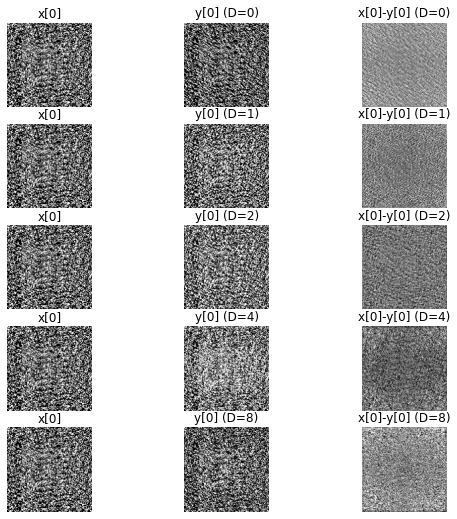

In [ ]:
x, _ = train_set[-1]
x = x.unsqueeze(0).to(device)
Ds = [0, 1, 2, 4, 8]

fig, axes = plt.subplots(nrows=len(Ds), ncols=3, figsize=(9,9))
for i in range(len(Ds)):
    with torch.no_grad():
        model = DnCNN(Ds[i]).to(device)
        y = model.forward(x)

    myimshow(x[0], ax=axes[i][0])
    axes[i][0].set_title('x[0]')
    myimshow(y[0], ax=axes[i][1])
    axes[i][1].set_title(f'y[0] (D={Ds[i]})')
    myimshow(x[0]-y[0], ax=axes[i][2])
    axes[i][2].set_title(f'x[0]-y[0] (D={Ds[i]})')

In [ ]:
class DenoisingStatsManager(nt.StatsManager):

    def __init__(self):
        super(DenoisingStatsManager, self).__init__()

    def init(self):
        super(DenoisingStatsManager, self).init()
        self.running_psnr = 0

    def accumulate(self, loss, x, y, d):
        super(DenoisingStatsManager, self).accumulate(loss, x, y, d)
        n = x.shape[0] * x.shape[1] * x.shape[2] * x.shape[3]
        self.running_psnr += 10*torch.log10(4*n/(torch.norm(y-d)**2))

    def summarize(self):
        loss = super(DenoisingStatsManager, self).summarize()
        psnr = self.running_psnr / self.number_update
        return {'loss': loss, 'PSNR': psnr.cpu()}

In [ ]:
def plot(exp, fig, axes, noisy, visu_rate=2):
    if exp.epoch % visu_rate != 0:
        return
    with torch.no_grad():
        denoised = exp.net(noisy[None].to(net.device))[0]
    axes[0][0].clear()
    axes[0][1].clear()
    axes[1][0].clear()
    axes[1][1].clear()
    myimshow(noisy, ax=axes[0][0])
    axes[0][0].set_title('Noisy image')

    myimshow(denoised, ax=axes[0][1])
    axes[0][1].set_title('Denoised image')

    axes[1][0].plot([exp.history[k][0]['loss'] for k in range(exp.epoch)], label='training loss')
    axes[1][0].set_ylabel('Loss')
    axes[1][0].set_xlabel('Epoch')
    axes[1][0].legend()

    axes[1][1].plot([exp.history[k][0]['PSNR'] for k in range(exp.epoch)], label='training psnr')
    axes[1][1].set_ylabel('PSNR')
    axes[1][1].set_xlabel('Epoch')
    axes[1][1].legend()

    plt.tight_layout()
    fig.canvas.draw()

In [ ]:
lr = 1e-3
net = DnCNN(6).to(device)
adam = torch.optim.Adam(net.parameters(), lr=lr)
stats_manager = DenoisingStatsManager()
exp1 = nt.Experiment(net, train_set, test_set, adam, stats_manager, batch_size=4,
               output_dir="../checkpoints/denoising_exp1", perform_validation_during_training=True)

Start/Continue training from epoch 0
13 p50_9.png
0 199.png
1 g10_9.png
2 g20_9.png
3 g30_9.png
4 g40_9.png
5 g50_9.png
6 g60_9.png
7 g70_9.png
8 g80_9.png
9 p10_9.png
10 p20_9.png
11 p30_9.png
12 p40_9.png
13 p50_9.png
14 p60_9.png
15 p70_9.png
16 p80_9.png
17 s10_9.png
18 s20_9.png
19 s30_9.png
20 s40_9.png
21 s50_9.png
22 s60_9.png
23 s70_9.png
Epoch 1 | Time: 14.10s | Training Loss: 0.222808 | Evaluation Loss: 0.077415
13 p50_9.png
0 199.png
1 g10_9.png
2 g20_9.png
3 g30_9.png
4 g40_9.png
5 g50_9.png
6 g60_9.png
7 g70_9.png
8 g80_9.png
9 p10_9.png
10 p20_9.png
11 p30_9.png
12 p40_9.png
13 p50_9.png
14 p60_9.png
15 p70_9.png
16 p80_9.png
17 s10_9.png
18 s20_9.png
19 s30_9.png
20 s40_9.png
21 s50_9.png
22 s60_9.png
23 s70_9.png
Epoch 2 | Time: 1.52s | Training Loss: 0.070574 | Evaluation Loss: 0.079477
13 p50_9.png
0 199.png
1 g10_9.png
2 g20_9.png
3 g30_9.png
4 g40_9.png
5 g50_9.png
6 g60_9.png
7 g70_9.png
8 g80_9.png
9 p10_9.png
10 p20_9.png
11 p30_9.png
12 p40_9.png
13 p50_9.png
1

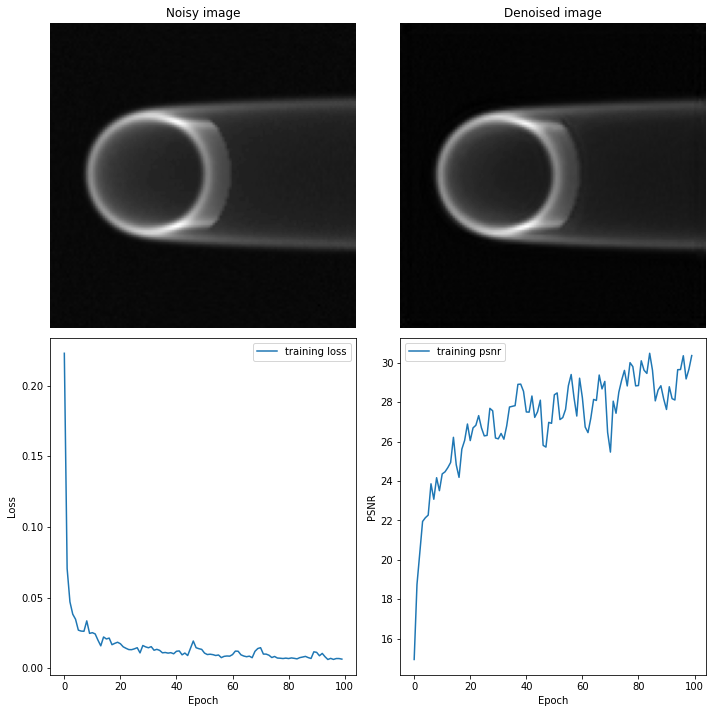

In [ ]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(10, 10))
exp1.run(num_epochs=100, plot=lambda exp: plot(exp, fig=fig, axes=axes,
                                                noisy=test_set[13][0]))

In [ ]:
def myimshow2(image, ax=plt):
    image = image.to('cpu').numpy()
    image = np.moveaxis(image, [0, 1, 2], [2, 0, 1])
    image = (image + 1) / 2
    image[image < 0] = 0
    image[image > 1] = 1
    image = image.squeeze()
    h = ax.imshow(image, cmap = 'gray')
    ax.axis('off')
    return image

In [ ]:
def myimshow3(image, ax=plt):
    image = image.detach().cpu().numpy()
    image = np.moveaxis(image, [0, 1, 2], [2, 0, 1])
    image = (image + 1) / 2
    image[image < 0] = 0
    image[image > 1] = 1
    image = image.squeeze()
    h = ax.imshow(image, cmap = 'gray', interpolation = 'nearest')
    ax.axis('off')
    return image

1 g10_9.png


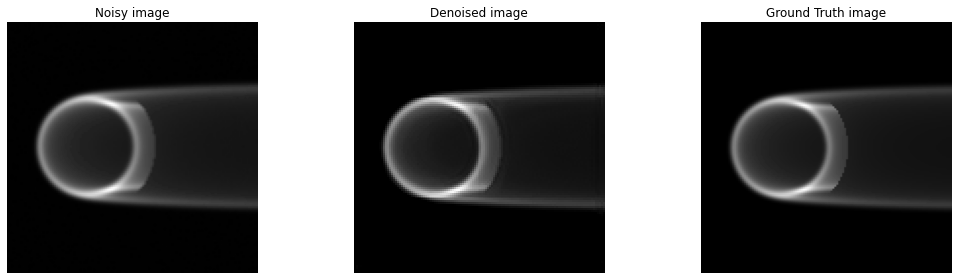

In [ ]:
im = test_set[1]
noisy = im[0]
denoised = exp1.net(noisy[None].to(net.device))[0]
fig, ((ax1,ax2,ax3)) = plt.subplots(ncols=3, nrows=1, figsize=(15, 4))
noisy_np = myimshow2(noisy, ax1)
ax1.set_title('Noisy image')
# plt.savefig('Noisy')
denoised_np = myimshow3(denoised, ax2)
ax2.set_title('Denoised image')
groundTruth_np = myimshow2(im[1], ax3)
ax3.set_title('Ground Truth image')
plt.tight_layout()
fig.canvas.draw()
# plt.savefig('309_DnCNN')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cbook as cbook
from matplotlib import cm

(-0.5, 127.5, 127.5, -0.5)

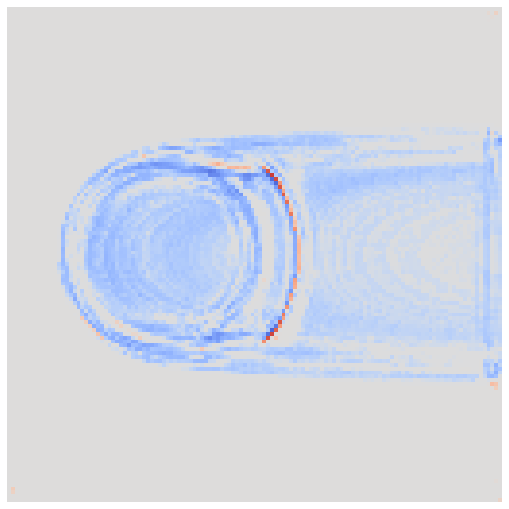

In [ ]:
abs = (denoised_np - groundTruth_np)
#abs_int = abs.astype(int)
fig, ((ax1)) = plt.subplots(nrows=1, ncols=1, figsize = (9.1,9.1))
h = ax1.imshow(abs, norm=colors.SymLogNorm(linthresh=0.01, linscale=0.01,vmin=-0.15, vmax=0.15, base=10), cmap = 'coolwarm', interpolation = 'nearest')
#fig.colorbar(h)
ax1.axis('off')

In [ ]:
import math
import cv2
def psnr(im1, im2):
	mse = np.mean((im1-im2)**2)
	if mse==0:
		return 100
	return 20*np.log10(1/np.sqrt(mse))

def ssim(img1, img2):
    C1 = 0.0
    C2 = 0.0

    img1 = img1.astype(np.float64)
    img2 = img2.astype(np.float64)
    kernel = cv2.getGaussianKernel(11, 1.5)
    window = np.outer(kernel, kernel.transpose())

    mu1 = cv2.filter2D(img1, -1, window)[5:-5, 5:-5]  # valid
    mu2 = cv2.filter2D(img2, -1, window)[5:-5, 5:-5]
    mu1_sq = mu1**2
    mu2_sq = mu2**2
    mu1_mu2 = mu1 * mu2
    sigma1_sq = cv2.filter2D(img1**2, -1, window)[5:-5, 5:-5] - mu1_sq
    sigma2_sq = cv2.filter2D(img2**2, -1, window)[5:-5, 5:-5] - mu2_sq
    sigma12 = cv2.filter2D(img1 * img2, -1, window)[5:-5, 5:-5] - mu1_mu2

    ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) *
                                                            (sigma1_sq + sigma2_sq + C2))

    return ssim_map.mean()


def calculate_ssim(img1, img2):
    '''calculate SSIM
    the same outputs as MATLAB's
    img1, img2: [0, 255]
    '''
    if not img1.shape == img2.shape:
        raise ValueError('Input images must have the same dimensions.')
    if img1.ndim == 2:
        return ssim(img1, img2)
    elif img1.ndim == 3:
        if img1.shape[2] == 3:
            ssims = []
            for i in range(3):
                ssims.append(ssim(img1, img2))
            return np.array(ssims).mean()
        elif img1.shape[2] == 1:
            return ssim(np.squeeze(img1), np.squeeze(img2))
    else:
        raise ValueError('Wrong input image dimensions.')

In [ ]:
print(psnr(denoised_np,groundTruth_np))
print(psnr(noisy_np,groundTruth_np))
print(calculate_ssim(denoised_np,groundTruth_np))
print(calculate_ssim(noisy_np,groundTruth_np))

38.182542649421414
32.645525282462664
nan
0.4250078803717194


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:179: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


5 g50_9.png
denoised psnr39.08316763439111
noisy psnr 29.350583041272355
denoised ssim 0.39622989294925964
moisy ssim 0.3558212474459265


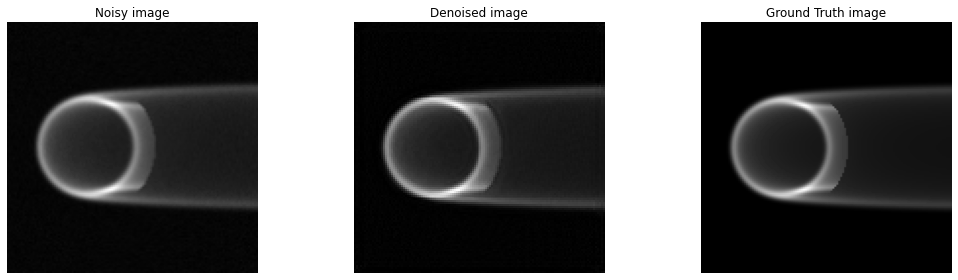

In [ ]:
im = test_set[5]
noisy = im[0]
denoised = exp1.net(noisy[None].to(net.device))[0]
fig, ((ax1,ax2,ax3)) = plt.subplots(ncols=3, nrows=1, figsize=(15, 4))
noisy_np = myimshow2(noisy, ax1)
ax1.set_title('Noisy image')
# plt.savefig('Noisy')
denoised_np = myimshow3(denoised, ax2)
ax2.set_title('Denoised image')
groundTruth_np = myimshow2(im[1], ax3)
ax3.set_title('Ground Truth image')
plt.tight_layout()
fig.canvas.draw()
# plt.savefig('309_DnCNN')

print(f'denoised psnr{psnr(denoised_np,groundTruth_np)}')
print(f'noisy psnr {psnr(noisy_np,groundTruth_np)}')
print(f'denoised ssim {calculate_ssim(denoised_np,groundTruth_np)}')
print(f'moisy ssim {calculate_ssim(noisy_np,groundTruth_np)}')

1 g10_9.png
38.182542649421414
32.645525282462664
nan
0.4250078803717194


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide


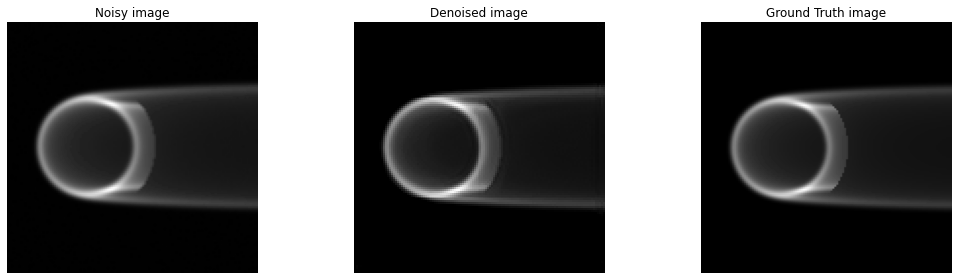

In [ ]:
im = test_set[1]
noisy = im[0]
denoised = exp1.net(noisy[None].to(net.device))[0]
fig, ((ax1,ax2,ax3)) = plt.subplots(ncols=3, nrows=1, figsize=(15, 4))
noisy_np = myimshow2(noisy, ax1)
ax1.set_title('Noisy image')
# plt.savefig('Noisy')
denoised_np = myimshow3(denoised, ax2)
ax2.set_title('Denoised image')
groundTruth_np = myimshow2(im[1], ax3)
ax3.set_title('Ground Truth image')
plt.tight_layout()
fig.canvas.draw()
# plt.savefig('309_DnCNN')

print(psnr(denoised_np,groundTruth_np))
print(psnr(noisy_np,groundTruth_np))
print(calculate_ssim(denoised_np,groundTruth_np))
print(calculate_ssim(noisy_np,groundTruth_np))

2 g20_9.png
denoised psnr39.60726184381293
noisy psnr 32.118202605508024
denoised ssim nan
moisy ssim 0.40963764118690826


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide


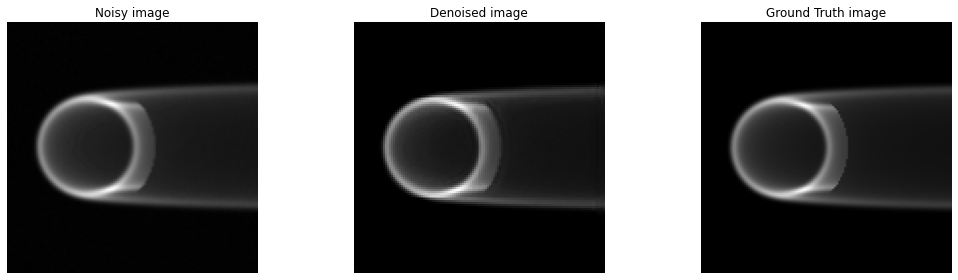

In [ ]:
im = test_set[2]
noisy = im[0]
denoised = exp1.net(noisy[None].to(net.device))[0]
fig, ((ax1,ax2,ax3)) = plt.subplots(ncols=3, nrows=1, figsize=(15, 4))
noisy_np = myimshow2(noisy, ax1)
ax1.set_title('Noisy image')
# plt.savefig('Noisy')
denoised_np = myimshow3(denoised, ax2)
ax2.set_title('Denoised image')
groundTruth_np = myimshow2(im[1], ax3)
ax3.set_title('Ground Truth image')
plt.tight_layout()
fig.canvas.draw()
# plt.savefig('309_DnCNN')

print(f'denoised psnr{psnr(denoised_np,groundTruth_np)}')
print(f'noisy psnr {psnr(noisy_np,groundTruth_np)}')
print(f'denoised ssim {calculate_ssim(denoised_np,groundTruth_np)}')
print(f'moisy ssim {calculate_ssim(noisy_np,groundTruth_np)}')

3 g30_9.png
denoised psnr41.35077609792637
noisy psnr 31.232788272916817
denoised ssim 0.44919598952057976
moisy ssim 0.38793140275882854


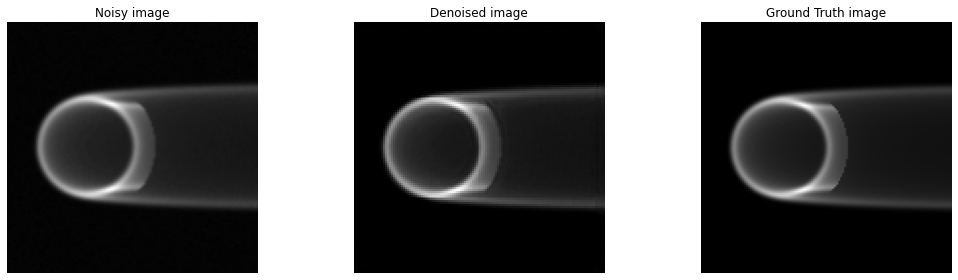

In [ ]:
im = test_set[3]
noisy = im[0]
denoised = exp1.net(noisy[None].to(net.device))[0]
fig, ((ax1,ax2,ax3)) = plt.subplots(ncols=3, nrows=1, figsize=(15, 4))
noisy_np = myimshow2(noisy, ax1)
ax1.set_title('Noisy image')
# plt.savefig('Noisy')
denoised_np = myimshow3(denoised, ax2)
ax2.set_title('Denoised image')
groundTruth_np = myimshow2(im[1], ax3)
ax3.set_title('Ground Truth image')
plt.tight_layout()
fig.canvas.draw()
# plt.savefig('309_DnCNN')

print(f'denoised psnr{psnr(denoised_np,groundTruth_np)}')
print(f'noisy psnr {psnr(noisy_np,groundTruth_np)}')
print(f'denoised ssim {calculate_ssim(denoised_np,groundTruth_np)}')
print(f'moisy ssim {calculate_ssim(noisy_np,groundTruth_np)}')

4 g40_9.png
denoised psnr41.23302740553987
noisy psnr 30.239351014241137
denoised ssim 0.4096430249287997
moisy ssim 0.36393128565577776


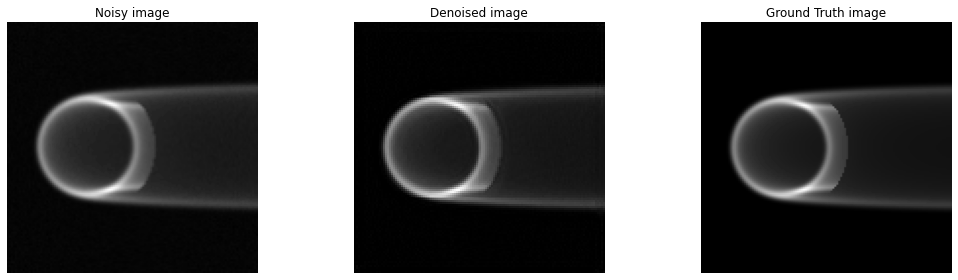

In [ ]:
im = test_set[4]
noisy = im[0]
denoised = exp1.net(noisy[None].to(net.device))[0]
fig, ((ax1,ax2,ax3)) = plt.subplots(ncols=3, nrows=1, figsize=(15, 4))
noisy_np = myimshow2(noisy, ax1)
ax1.set_title('Noisy image')
# plt.savefig('Noisy')
denoised_np = myimshow3(denoised, ax2)
ax2.set_title('Denoised image')
groundTruth_np = myimshow2(im[1], ax3)
ax3.set_title('Ground Truth image')
plt.tight_layout()
fig.canvas.draw()
# plt.savefig('309_DnCNN')

print(f'denoised psnr{psnr(denoised_np,groundTruth_np)}')
print(f'noisy psnr {psnr(noisy_np,groundTruth_np)}')
print(f'denoised ssim {calculate_ssim(denoised_np,groundTruth_np)}')
print(f'moisy ssim {calculate_ssim(noisy_np,groundTruth_np)}')

5 g50_9.png
denoised psnr39.08316763439111
noisy psnr 29.350583041272355
denoised ssim 0.39622989294925964
moisy ssim 0.3558212474459265


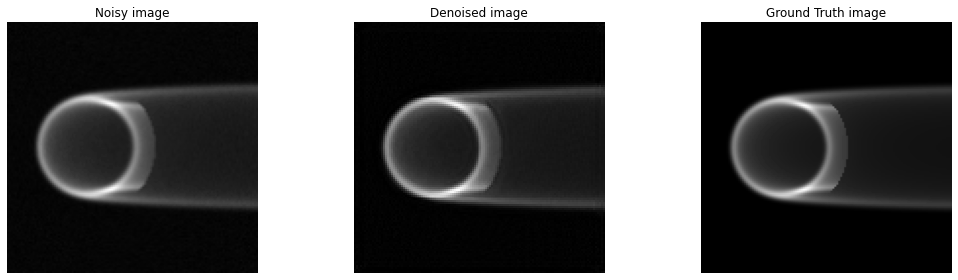

In [ ]:
im = test_set[5]
noisy = im[0]
denoised = exp1.net(noisy[None].to(net.device))[0]
fig, ((ax1,ax2,ax3)) = plt.subplots(ncols=3, nrows=1, figsize=(15, 4))
noisy_np = myimshow2(noisy, ax1)
ax1.set_title('Noisy image')
# plt.savefig('Noisy')
denoised_np = myimshow3(denoised, ax2)
ax2.set_title('Denoised image')
groundTruth_np = myimshow2(im[1], ax3)
ax3.set_title('Ground Truth image')
plt.tight_layout()
fig.canvas.draw()
# plt.savefig('309_DnCNN')

print(f'denoised psnr{psnr(denoised_np,groundTruth_np)}')
print(f'noisy psnr {psnr(noisy_np,groundTruth_np)}')
print(f'denoised ssim {calculate_ssim(denoised_np,groundTruth_np)}')
print(f'moisy ssim {calculate_ssim(noisy_np,groundTruth_np)}')

6 g60_9.png
denoised psnr38.18890035083189
noisy psnr 28.85718560869462
denoised ssim 0.38336750691472604
moisy ssim 0.3390826866309038


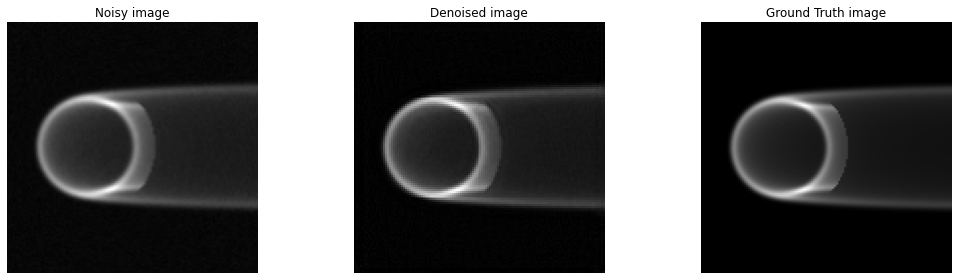

In [ ]:
im = test_set[6]
noisy = im[0]
denoised = exp1.net(noisy[None].to(net.device))[0]
fig, ((ax1,ax2,ax3)) = plt.subplots(ncols=3, nrows=1, figsize=(15, 4))
noisy_np = myimshow2(noisy, ax1)
ax1.set_title('Noisy image')
# plt.savefig('Noisy')
denoised_np = myimshow3(denoised, ax2)
ax2.set_title('Denoised image')
groundTruth_np = myimshow2(im[1], ax3)
ax3.set_title('Ground Truth image')
plt.tight_layout()
fig.canvas.draw()
# plt.savefig('309_DnCNN')

print(f'denoised psnr{psnr(denoised_np,groundTruth_np)}')
print(f'noisy psnr {psnr(noisy_np,groundTruth_np)}')
print(f'denoised ssim {calculate_ssim(denoised_np,groundTruth_np)}')
print(f'moisy ssim {calculate_ssim(noisy_np,groundTruth_np)}')

7 g70_9.png
denoised psnr36.47229711234389
noisy psnr 28.390302499742806
denoised ssim 0.37236386422452933
moisy ssim 0.3291546797990694


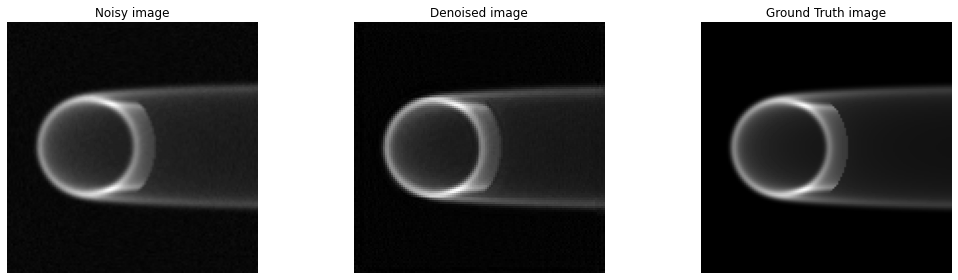

In [ ]:
im = test_set[7]
noisy = im[0]
denoised = exp1.net(noisy[None].to(net.device))[0]
fig, ((ax1,ax2,ax3)) = plt.subplots(ncols=3, nrows=1, figsize=(15, 4))
noisy_np = myimshow2(noisy, ax1)
ax1.set_title('Noisy image')
# plt.savefig('Noisy')
denoised_np = myimshow3(denoised, ax2)
ax2.set_title('Denoised image')
groundTruth_np = myimshow2(im[1], ax3)
ax3.set_title('Ground Truth image')
plt.tight_layout()
fig.canvas.draw()
# plt.savefig('309_DnCNN')

print(f'denoised psnr{psnr(denoised_np,groundTruth_np)}')
print(f'noisy psnr {psnr(noisy_np,groundTruth_np)}')
print(f'denoised ssim {calculate_ssim(denoised_np,groundTruth_np)}')
print(f'moisy ssim {calculate_ssim(noisy_np,groundTruth_np)}')

8 g80_9.png
denoised psnr33.6043709771551
noisy psnr 27.206589874383443
denoised ssim 0.36011948612398
moisy ssim 0.3154988430815579


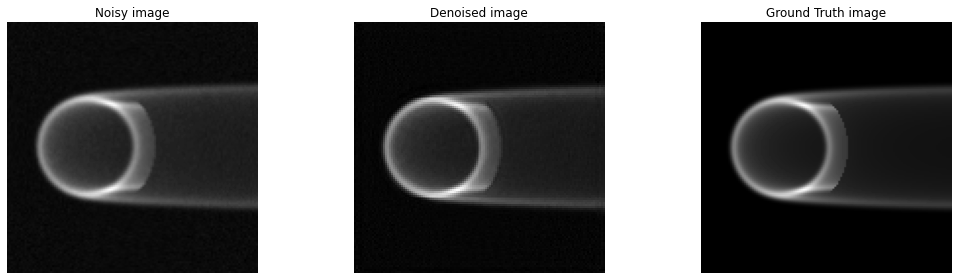

In [ ]:
im = test_set[8]
noisy = im[0]
denoised = exp1.net(noisy[None].to(net.device))[0]
fig, ((ax1,ax2,ax3)) = plt.subplots(ncols=3, nrows=1, figsize=(15, 4))
noisy_np = myimshow2(noisy, ax1)
ax1.set_title('Noisy image')
# plt.savefig('Noisy')
denoised_np = myimshow3(denoised, ax2)
ax2.set_title('Denoised image')
groundTruth_np = myimshow2(im[1], ax3)
ax3.set_title('Ground Truth image')
plt.tight_layout()
fig.canvas.draw()
# plt.savefig('309_DnCNN')

print(f'denoised psnr{psnr(denoised_np,groundTruth_np)}')
print(f'noisy psnr {psnr(noisy_np,groundTruth_np)}')
print(f'denoised ssim {calculate_ssim(denoised_np,groundTruth_np)}')
print(f'moisy ssim {calculate_ssim(noisy_np,groundTruth_np)}')

9 p10_9.png
denoised psnr38.91034322176462
noisy psnr 32.437759758411914
denoised ssim nan
moisy ssim 0.4315723526368538


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide


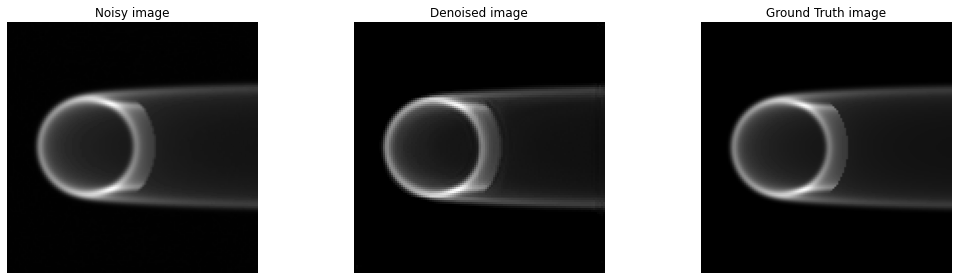

In [ ]:
im = test_set[9]
noisy = im[0]
denoised = exp1.net(noisy[None].to(net.device))[0]
fig, ((ax1,ax2,ax3)) = plt.subplots(ncols=3, nrows=1, figsize=(15, 4))
noisy_np = myimshow2(noisy, ax1)
ax1.set_title('Noisy image')
# plt.savefig('Noisy')
denoised_np = myimshow3(denoised, ax2)
ax2.set_title('Denoised image')
groundTruth_np = myimshow2(im[1], ax3)
ax3.set_title('Ground Truth image')
plt.tight_layout()
fig.canvas.draw()
# plt.savefig('309_DnCNN')

print(f'denoised psnr{psnr(denoised_np,groundTruth_np)}')
print(f'noisy psnr {psnr(noisy_np,groundTruth_np)}')
print(f'denoised ssim {calculate_ssim(denoised_np,groundTruth_np)}')
print(f'moisy ssim {calculate_ssim(noisy_np,groundTruth_np)}')

10 p20_9.png
denoised psnr41.42375591993532
noisy psnr 31.38762709290273
denoised ssim 0.4728425200981073
moisy ssim 0.409323224058778


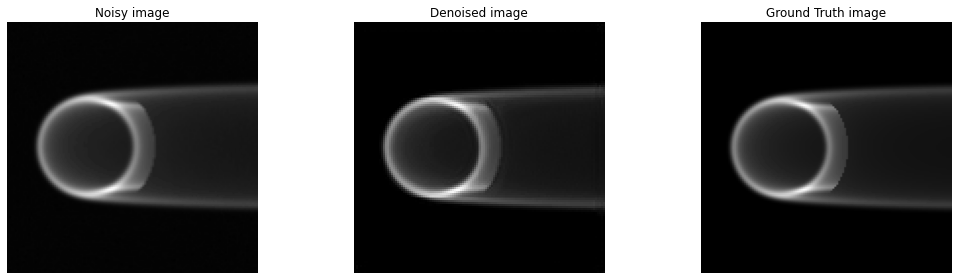

In [ ]:
im = test_set[10]
noisy = im[0]
denoised = exp1.net(noisy[None].to(net.device))[0]
fig, ((ax1,ax2,ax3)) = plt.subplots(ncols=3, nrows=1, figsize=(15, 4))
noisy_np = myimshow2(noisy, ax1)
ax1.set_title('Noisy image')
# plt.savefig('Noisy')
denoised_np = myimshow3(denoised, ax2)
ax2.set_title('Denoised image')
groundTruth_np = myimshow2(im[1], ax3)
ax3.set_title('Ground Truth image')
plt.tight_layout()
fig.canvas.draw()
# plt.savefig('309_DnCNN')

print(f'denoised psnr{psnr(denoised_np,groundTruth_np)}')
print(f'noisy psnr {psnr(noisy_np,groundTruth_np)}')
print(f'denoised ssim {calculate_ssim(denoised_np,groundTruth_np)}')
print(f'moisy ssim {calculate_ssim(noisy_np,groundTruth_np)}')

11 p30_9.png
denoised psnr41.41568948925479
noisy psnr 30.416325759256594
denoised ssim 0.4306286945935368
moisy ssim 0.3906318545455326


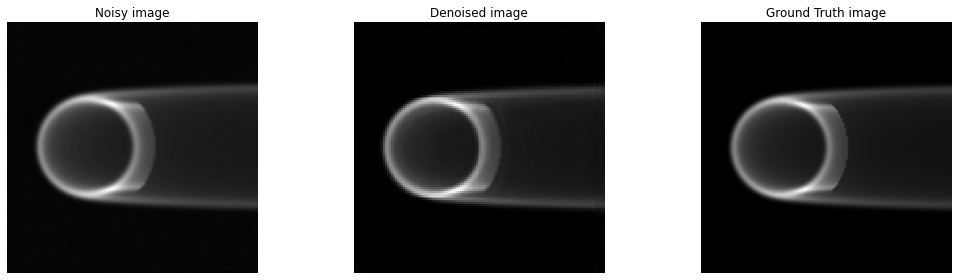

In [ ]:
im = test_set[11]
noisy = im[0]
denoised = exp1.net(noisy[None].to(net.device))[0]
fig, ((ax1,ax2,ax3)) = plt.subplots(ncols=3, nrows=1, figsize=(15, 4))
noisy_np = myimshow2(noisy, ax1)
ax1.set_title('Noisy image')
# plt.savefig('Noisy')
denoised_np = myimshow3(denoised, ax2)
ax2.set_title('Denoised image')
groundTruth_np = myimshow2(im[1], ax3)
ax3.set_title('Ground Truth image')
plt.tight_layout()
fig.canvas.draw()
# plt.savefig('309_DnCNN')

print(f'denoised psnr{psnr(denoised_np,groundTruth_np)}')
print(f'noisy psnr {psnr(noisy_np,groundTruth_np)}')
print(f'denoised ssim {calculate_ssim(denoised_np,groundTruth_np)}')
print(f'moisy ssim {calculate_ssim(noisy_np,groundTruth_np)}')

12 p40_9.png
denoised psnr38.73206945028132
noisy psnr 29.213991948971746
denoised ssim 0.4130700359976569
moisy ssim 0.3796872202523741


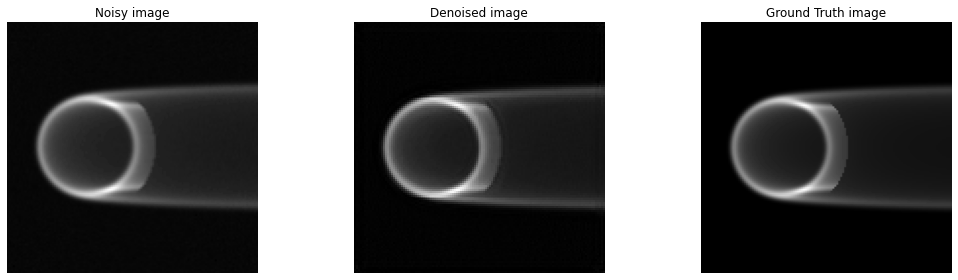

In [ ]:
im = test_set[12]
noisy = im[0]
denoised = exp1.net(noisy[None].to(net.device))[0]
fig, ((ax1,ax2,ax3)) = plt.subplots(ncols=3, nrows=1, figsize=(15, 4))
noisy_np = myimshow2(noisy, ax1)
ax1.set_title('Noisy image')
# plt.savefig('Noisy')
denoised_np = myimshow3(denoised, ax2)
ax2.set_title('Denoised image')
groundTruth_np = myimshow2(im[1], ax3)
ax3.set_title('Ground Truth image')
plt.tight_layout()
fig.canvas.draw()
# plt.savefig('309_DnCNN')

print(f'denoised psnr{psnr(denoised_np,groundTruth_np)}')
print(f'noisy psnr {psnr(noisy_np,groundTruth_np)}')
print(f'denoised ssim {calculate_ssim(denoised_np,groundTruth_np)}')
print(f'moisy ssim {calculate_ssim(noisy_np,groundTruth_np)}')

13 p50_9.png
denoised psnr35.61007655327345
noisy psnr 28.039636227557946
denoised ssim 0.39504149574972913
moisy ssim 0.3602565758685501


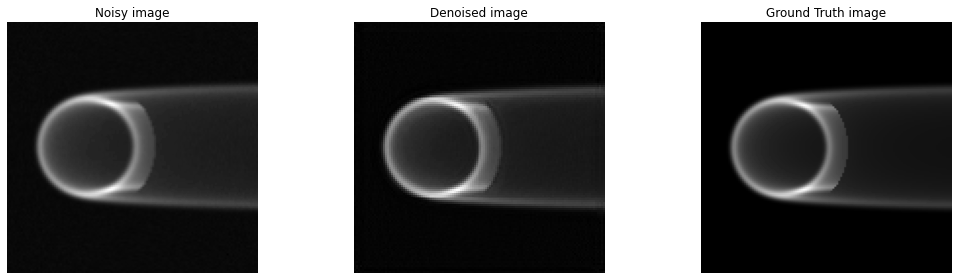

In [ ]:
im = test_set[13]
noisy = im[0]
denoised = exp1.net(noisy[None].to(net.device))[0]
fig, ((ax1,ax2,ax3)) = plt.subplots(ncols=3, nrows=1, figsize=(15, 4))
noisy_np = myimshow2(noisy, ax1)
ax1.set_title('Noisy image')
# plt.savefig('Noisy')
denoised_np = myimshow3(denoised, ax2)
ax2.set_title('Denoised image')
groundTruth_np = myimshow2(im[1], ax3)
ax3.set_title('Ground Truth image')
plt.tight_layout()
fig.canvas.draw()
# plt.savefig('309_DnCNN')

print(f'denoised psnr{psnr(denoised_np,groundTruth_np)}')
print(f'noisy psnr {psnr(noisy_np,groundTruth_np)}')
print(f'denoised ssim {calculate_ssim(denoised_np,groundTruth_np)}')
print(f'moisy ssim {calculate_ssim(noisy_np,groundTruth_np)}')

14 p60_9.png
denoised psnr32.86723322504084
noisy psnr 26.76596889695052
denoised ssim 0.37971472584848365
moisy ssim 0.3441695440130156


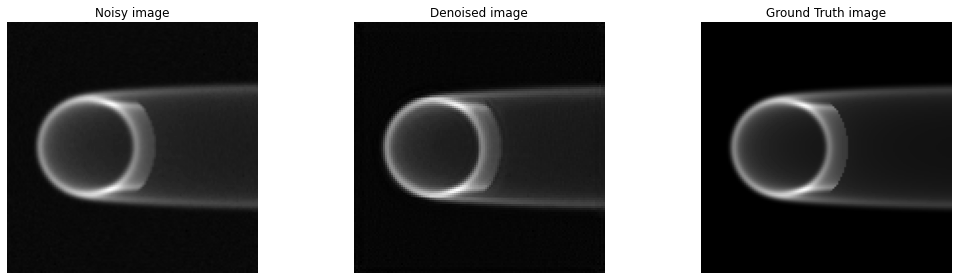

In [ ]:
im = test_set[14]
noisy = im[0]
denoised = exp1.net(noisy[None].to(net.device))[0]
fig, ((ax1,ax2,ax3)) = plt.subplots(ncols=3, nrows=1, figsize=(15, 4))
noisy_np = myimshow2(noisy, ax1)
ax1.set_title('Noisy image')
# plt.savefig('Noisy')
denoised_np = myimshow3(denoised, ax2)
ax2.set_title('Denoised image')
groundTruth_np = myimshow2(im[1], ax3)
ax3.set_title('Ground Truth image')
plt.tight_layout()
fig.canvas.draw()
# plt.savefig('309_DnCNN')

print(f'denoised psnr{psnr(denoised_np,groundTruth_np)}')
print(f'noisy psnr {psnr(noisy_np,groundTruth_np)}')
print(f'denoised ssim {calculate_ssim(denoised_np,groundTruth_np)}')
print(f'moisy ssim {calculate_ssim(noisy_np,groundTruth_np)}')

15 p70_9.png
denoised psnr30.265654781288703
noisy psnr 25.552976800123652
denoised ssim 0.3705712507094273
moisy ssim 0.33451432516294394


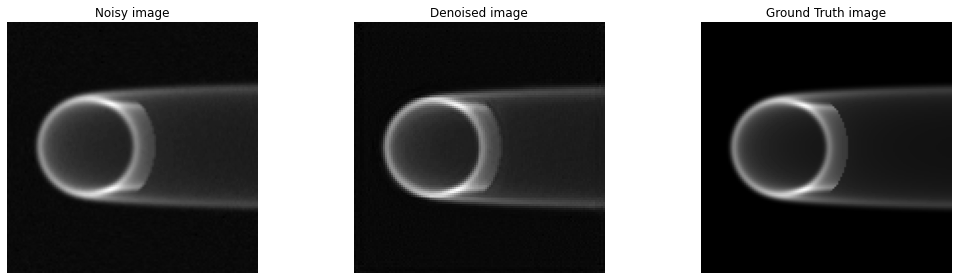

In [ ]:
im = test_set[15]
noisy = im[0]
denoised = exp1.net(noisy[None].to(net.device))[0]
fig, ((ax1,ax2,ax3)) = plt.subplots(ncols=3, nrows=1, figsize=(15, 4))
noisy_np = myimshow2(noisy, ax1)
ax1.set_title('Noisy image')
# plt.savefig('Noisy')
denoised_np = myimshow3(denoised, ax2)
ax2.set_title('Denoised image')
groundTruth_np = myimshow2(im[1], ax3)
ax3.set_title('Ground Truth image')
plt.tight_layout()
fig.canvas.draw()
# plt.savefig('309_DnCNN')

print(f'denoised psnr{psnr(denoised_np,groundTruth_np)}')
print(f'noisy psnr {psnr(noisy_np,groundTruth_np)}')
print(f'denoised ssim {calculate_ssim(denoised_np,groundTruth_np)}')
print(f'moisy ssim {calculate_ssim(noisy_np,groundTruth_np)}')

16 p80_9.png
denoised psnr28.72944624356835
noisy psnr 24.698346033984905
denoised ssim 0.36134936168664994
moisy ssim 0.3233554839343572


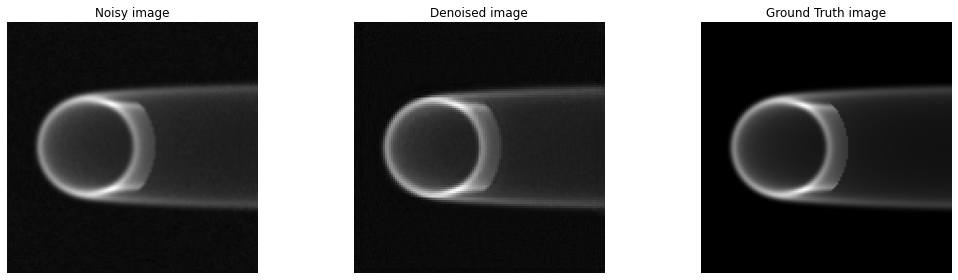

In [ ]:
im = test_set[16]
noisy = im[0]
denoised = exp1.net(noisy[None].to(net.device))[0]
fig, ((ax1,ax2,ax3)) = plt.subplots(ncols=3, nrows=1, figsize=(15, 4))
noisy_np = myimshow2(noisy, ax1)
ax1.set_title('Noisy image')
# plt.savefig('Noisy')
denoised_np = myimshow3(denoised, ax2)
ax2.set_title('Denoised image')
groundTruth_np = myimshow2(im[1], ax3)
ax3.set_title('Ground Truth image')
plt.tight_layout()
fig.canvas.draw()
# plt.savefig('309_DnCNN')

print(f'denoised psnr{psnr(denoised_np,groundTruth_np)}')
print(f'noisy psnr {psnr(noisy_np,groundTruth_np)}')
print(f'denoised ssim {calculate_ssim(denoised_np,groundTruth_np)}')
print(f'moisy ssim {calculate_ssim(noisy_np,groundTruth_np)}')

17 s10_9.png
denoised psnr30.194062685174178
noisy psnr 15.690126406692201
denoised ssim 0.2519823219049027
moisy ssim 0.1274657381177441


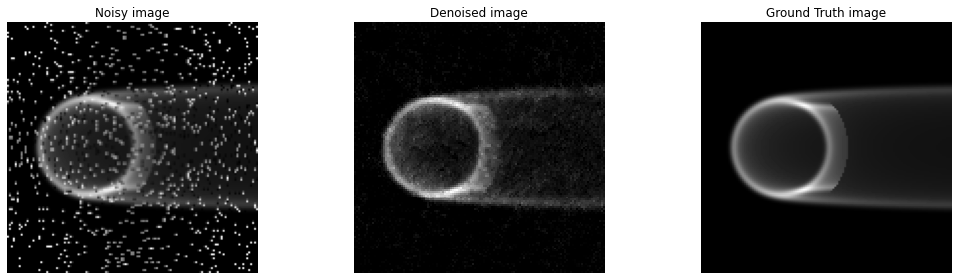

In [ ]:
im = test_set[17]
noisy = im[0]
denoised = exp1.net(noisy[None].to(net.device))[0]
fig, ((ax1,ax2,ax3)) = plt.subplots(ncols=3, nrows=1, figsize=(15, 4))
noisy_np = myimshow2(noisy, ax1)
ax1.set_title('Noisy image')
# plt.savefig('Noisy')
denoised_np = myimshow3(denoised, ax2)
ax2.set_title('Denoised image')
groundTruth_np = myimshow2(im[1], ax3)
ax3.set_title('Ground Truth image')
plt.tight_layout()
fig.canvas.draw()
# plt.savefig('309_DnCNN')

print(f'denoised psnr{psnr(denoised_np,groundTruth_np)}')
print(f'noisy psnr {psnr(noisy_np,groundTruth_np)}')
print(f'denoised ssim {calculate_ssim(denoised_np,groundTruth_np)}')
print(f'moisy ssim {calculate_ssim(noisy_np,groundTruth_np)}')

18 s20_9.png
denoised psnr27.687422168295544
noisy psnr 12.872331881407755
denoised ssim 0.21058314304983536
moisy ssim 0.07918361962917446


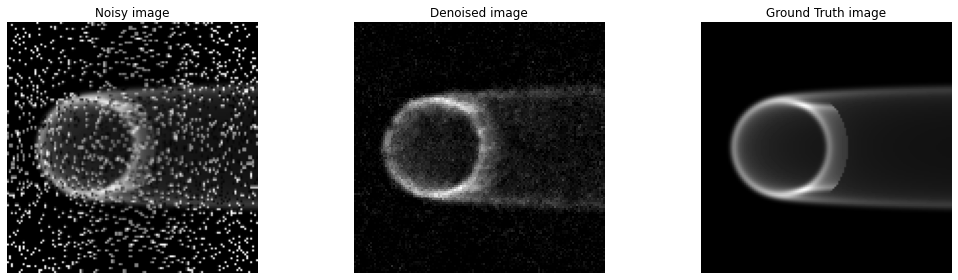

In [ ]:
im = test_set[18]
noisy = im[0]
denoised = exp1.net(noisy[None].to(net.device))[0]
fig, ((ax1,ax2,ax3)) = plt.subplots(ncols=3, nrows=1, figsize=(15, 4))
noisy_np = myimshow2(noisy, ax1)
ax1.set_title('Noisy image')
# plt.savefig('Noisy')
denoised_np = myimshow3(denoised, ax2)
ax2.set_title('Denoised image')
groundTruth_np = myimshow2(im[1], ax3)
ax3.set_title('Ground Truth image')
plt.tight_layout()
fig.canvas.draw()
# plt.savefig('309_DnCNN')

print(f'denoised psnr{psnr(denoised_np,groundTruth_np)}')
print(f'noisy psnr {psnr(noisy_np,groundTruth_np)}')
print(f'denoised ssim {calculate_ssim(denoised_np,groundTruth_np)}')
print(f'moisy ssim {calculate_ssim(noisy_np,groundTruth_np)}')

19 s30_9.png
denoised psnr25.498055779597642
noisy psnr 10.937497528381016
denoised ssim 0.16792147626681242
moisy ssim 0.0538891176273221


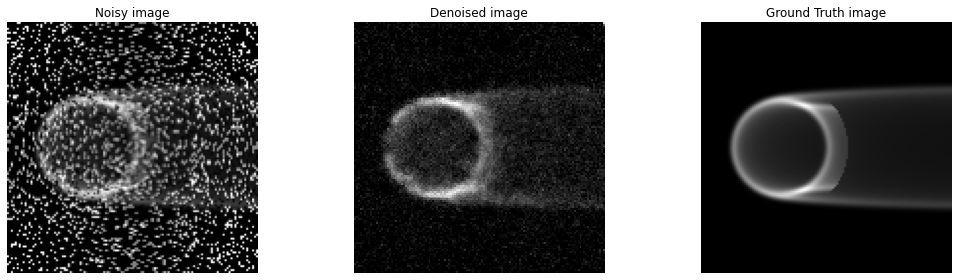

In [ ]:
im = test_set[19]
noisy = im[0]
denoised = exp1.net(noisy[None].to(net.device))[0]
fig, ((ax1,ax2,ax3)) = plt.subplots(ncols=3, nrows=1, figsize=(15, 4))
noisy_np = myimshow2(noisy, ax1)
ax1.set_title('Noisy image')
# plt.savefig('Noisy')
denoised_np = myimshow3(denoised, ax2)
ax2.set_title('Denoised image')
groundTruth_np = myimshow2(im[1], ax3)
ax3.set_title('Ground Truth image')
plt.tight_layout()
fig.canvas.draw()
# plt.savefig('309_DnCNN')

print(f'denoised psnr{psnr(denoised_np,groundTruth_np)}')
print(f'noisy psnr {psnr(noisy_np,groundTruth_np)}')
print(f'denoised ssim {calculate_ssim(denoised_np,groundTruth_np)}')
print(f'moisy ssim {calculate_ssim(noisy_np,groundTruth_np)}')

20 s40_9.png
denoised psnr22.844639871364155
noisy psnr 9.040093562604007
denoised ssim 0.13549057243039506
moisy ssim 0.04081774449791473


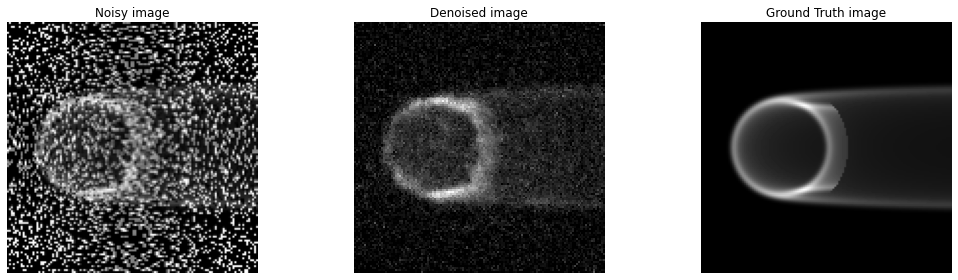

In [ ]:
im = test_set[20]
noisy = im[0]
denoised = exp1.net(noisy[None].to(net.device))[0]
fig, ((ax1,ax2,ax3)) = plt.subplots(ncols=3, nrows=1, figsize=(15, 4))
noisy_np = myimshow2(noisy, ax1)
ax1.set_title('Noisy image')
# plt.savefig('Noisy')
denoised_np = myimshow3(denoised, ax2)
ax2.set_title('Denoised image')
groundTruth_np = myimshow2(im[1], ax3)
ax3.set_title('Ground Truth image')
plt.tight_layout()
fig.canvas.draw()
# plt.savefig('309_DnCNN')

print(f'denoised psnr{psnr(denoised_np,groundTruth_np)}')
print(f'noisy psnr {psnr(noisy_np,groundTruth_np)}')
print(f'denoised ssim {calculate_ssim(denoised_np,groundTruth_np)}')
print(f'moisy ssim {calculate_ssim(noisy_np,groundTruth_np)}')

21 s50_9.png
denoised psnr20.802923469065803
noisy psnr 8.128038780199756
denoised ssim 0.09638084015173506
moisy ssim 0.0335833906490987


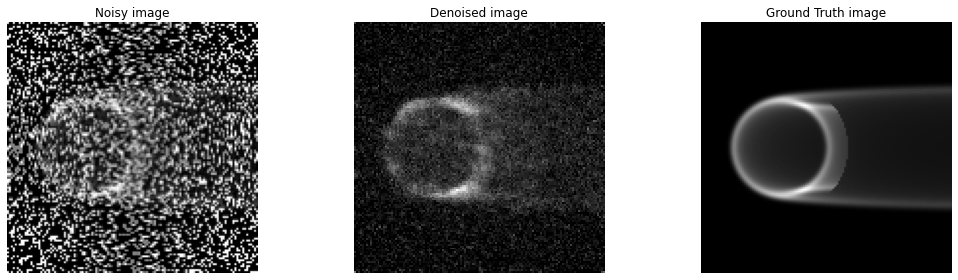

In [ ]:
im = test_set[21]
noisy = im[0]
denoised = exp1.net(noisy[None].to(net.device))[0]
fig, ((ax1,ax2,ax3)) = plt.subplots(ncols=3, nrows=1, figsize=(15, 4))
noisy_np = myimshow2(noisy, ax1)
ax1.set_title('Noisy image')
# plt.savefig('Noisy')
denoised_np = myimshow3(denoised, ax2)
ax2.set_title('Denoised image')
groundTruth_np = myimshow2(im[1], ax3)
ax3.set_title('Ground Truth image')
plt.tight_layout()
fig.canvas.draw()
# plt.savefig('309_DnCNN')

print(f'denoised psnr{psnr(denoised_np,groundTruth_np)}')
print(f'noisy psnr {psnr(noisy_np,groundTruth_np)}')
print(f'denoised ssim {calculate_ssim(denoised_np,groundTruth_np)}')
print(f'moisy ssim {calculate_ssim(noisy_np,groundTruth_np)}')

22 s60_9.png
denoised psnr19.27982301941746
noisy psnr 7.537779154881548
denoised ssim 0.07165145308904855
moisy ssim 0.024949300342927607


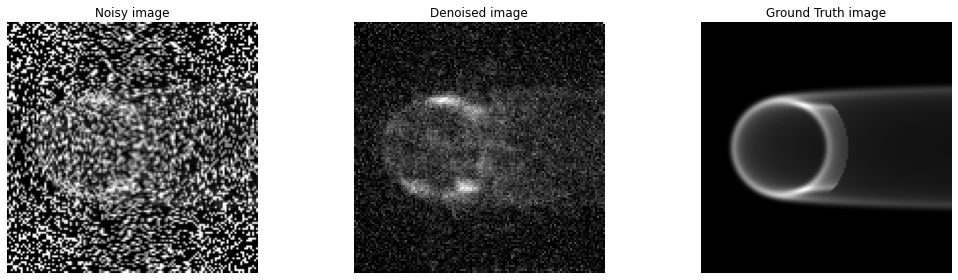

In [ ]:
im = test_set[22]
noisy = im[0]
denoised = exp1.net(noisy[None].to(net.device))[0]
fig, ((ax1,ax2,ax3)) = plt.subplots(ncols=3, nrows=1, figsize=(15, 4))
noisy_np = myimshow2(noisy, ax1)
ax1.set_title('Noisy image')
# plt.savefig('Noisy')
denoised_np = myimshow3(denoised, ax2)
ax2.set_title('Denoised image')
groundTruth_np = myimshow2(im[1], ax3)
ax3.set_title('Ground Truth image')
plt.tight_layout()
fig.canvas.draw()
# plt.savefig('309_DnCNN')

print(f'denoised psnr{psnr(denoised_np,groundTruth_np)}')
print(f'noisy psnr {psnr(noisy_np,groundTruth_np)}')
print(f'denoised ssim {calculate_ssim(denoised_np,groundTruth_np)}')
print(f'moisy ssim {calculate_ssim(noisy_np,groundTruth_np)}')

23 s70_9.png
denoised psnr17.64523465459243
noisy psnr 6.875381308539618
denoised ssim 0.04783768525509986
moisy ssim 0.012903682493549305


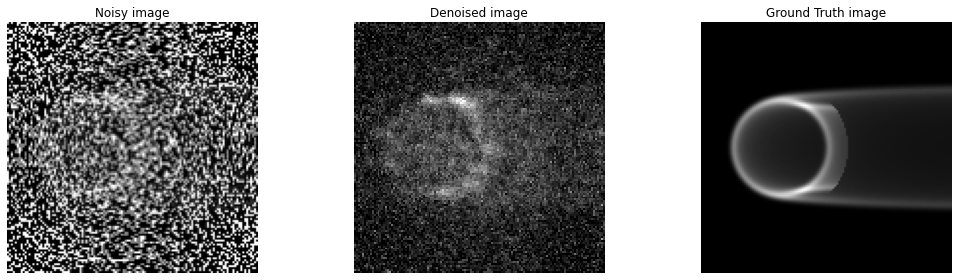

In [ ]:
im = test_set[23]
noisy = im[0]
denoised = exp1.net(noisy[None].to(net.device))[0]
fig, ((ax1,ax2,ax3)) = plt.subplots(ncols=3, nrows=1, figsize=(15, 4))
noisy_np = myimshow2(noisy, ax1)
ax1.set_title('Noisy image')
# plt.savefig('Noisy')
denoised_np = myimshow3(denoised, ax2)
ax2.set_title('Denoised image')
groundTruth_np = myimshow2(im[1], ax3)
ax3.set_title('Ground Truth image')
plt.tight_layout()
fig.canvas.draw()
# plt.savefig('309_DnCNN')

print(f'denoised psnr{psnr(denoised_np,groundTruth_np)}')
print(f'noisy psnr {psnr(noisy_np,groundTruth_np)}')
print(f'denoised ssim {calculate_ssim(denoised_np,groundTruth_np)}')
print(f'moisy ssim {calculate_ssim(noisy_np,groundTruth_np)}')

24 s80_9.png
denoised psnr15.533105048275031
noisy psnr 5.964363372063962
denoised ssim 0.02607302390585778
moisy ssim 0.008242391986567227


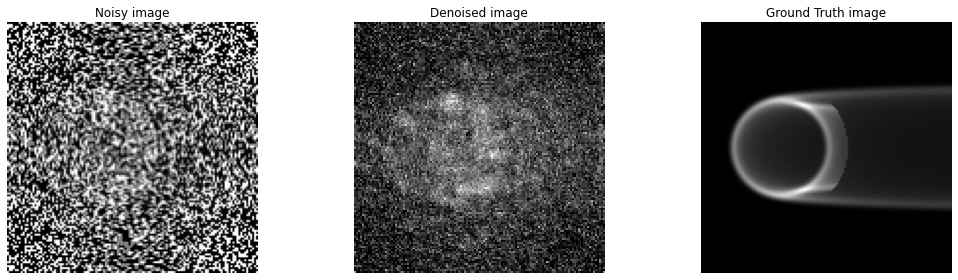

In [ ]:
im = test_set[24]
noisy = im[0]
denoised = exp1.net(noisy[None].to(net.device))[0]
fig, ((ax1,ax2,ax3)) = plt.subplots(ncols=3, nrows=1, figsize=(15, 4))
noisy_np = myimshow2(noisy, ax1)
ax1.set_title('Noisy image')
# plt.savefig('Noisy')
denoised_np = myimshow3(denoised, ax2)
ax2.set_title('Denoised image')
groundTruth_np = myimshow2(im[1], ax3)
ax3.set_title('Ground Truth image')
plt.tight_layout()
fig.canvas.draw()
# plt.savefig('309_DnCNN')

print(f'denoised psnr{psnr(denoised_np,groundTruth_np)}')
print(f'noisy psnr {psnr(noisy_np,groundTruth_np)}')
print(f'denoised ssim {calculate_ssim(denoised_np,groundTruth_np)}')
print(f'moisy ssim {calculate_ssim(noisy_np,groundTruth_np)}')